In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn, optim

from utils import load_all_data, squeeze_and_concat, filter_mask_keep_labels, multiclass_dice_loss
from datasets import MultiTissueDataset
from unet_advanced import UNetAdvanced
from train_utils import EarlyStopping



%load_ext autoreload
%autoreload 2

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")
print(f'Num available GPUs: ', torch.cuda.device_count())


p = torch.cuda.get_device_properties()
print(f"Device: {p.name} (Memory: {p.total_memory / 1e9:.2f} GB)")

Selected device: cuda
Num available GPUs:  1
Device: NVIDIA TITAN RTX (Memory: 25.19 GB)


In [3]:
# Data import 
DATA_FOLDER = "/scratch/pdiciano/GenAI/ACDC_mine/data/ACDC_tissue_prop"

data = load_all_data(DATA_FOLDER)
data_concat = squeeze_and_concat(data)

In [4]:
mask_keep_labels = [0, 1, 2, 3]  # ventricule right, ventricule left, myocardium right, myocardium left
data_concat['input_labels'] = filter_mask_keep_labels(data_concat['multiClassMasks'], mask_keep_labels)

In [5]:
dataset = MultiTissueDataset(data_concat)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [6]:
def train(model, dataloader):
    lr = 1e-3
    epochs = 100

    patience = 10
    delta = 0.005

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True)

    model.to(device)
    model.train()
    
    metrics = {
        'loss': [],
        'dice_score': []
    }

    for epoch in range(epochs):
        running_loss = 0.0
        n_samples = 0

        with tqdm(dataloader, desc=f"Epoch {epoch+1}") as loop:

            for batch in loop:
                model.train()

                inputs = batch['input_label']  # (B, C, H, W)
                targets = batch['multiClassMask']  # (B, H, W)

                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs) 
                loss = criterion(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_size = inputs.size(0)
                n_samples += batch_size
                running_loss += loss.item() * batch_size
                current_average_loss = running_loss / n_samples

                loop.set_postfix({'loss: ': f'{current_average_loss:.2f}',
                                'lr: ': f"{optimizer.param_groups[0]['lr']:.2e}"})
        
        scheduler.step()
        dice_score = multiclass_dice_loss(outputs, targets).item()

        metrics['loss'].append(current_average_loss)
        metrics['dice_score'].append(dice_score)

        # Check early stopping condition
        early_stopping.check_early_stop(current_average_loss)
        
        if early_stopping.stop_training:
            print(f"Early stopping at epoch {epoch}")
            break

        print(f"Epoch {epoch+1}/{epochs}, Loss: {current_average_loss:.4f}, 1-Dice Score: {dice_score:.4f}")


    return model, metrics


In [9]:
model = UNetAdvanced(in_ch=4, num_classes=12).to(device)

trained_model, metrics = train(model, dataloader)
torch.save(trained_model.state_dict(), './models/multiTissue_advanced_unet.pth')

Epoch 1: 100%|██████████| 103/103 [01:08<00:00,  1.51it/s, loss: =1.30, lr: =1.00e-03]


Epoch 1/100, Loss: 1.3015, 1-Dice Score: 0.5228


Epoch 2: 100%|██████████| 103/103 [01:08<00:00,  1.50it/s, loss: =1.16, lr: =9.76e-04]


Epoch 2/100, Loss: 1.1571, 1-Dice Score: 0.5198


Epoch 3: 100%|██████████| 103/103 [01:08<00:00,  1.49it/s, loss: =1.12, lr: =9.05e-04]


Epoch 3/100, Loss: 1.1214, 1-Dice Score: 0.5153


Epoch 4: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =1.09, lr: =7.94e-04]


Epoch 4/100, Loss: 1.0858, 1-Dice Score: 0.4720


Epoch 5: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =1.06, lr: =6.55e-04]


Epoch 5/100, Loss: 1.0551, 1-Dice Score: 0.4811


Epoch 6: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =1.03, lr: =5.00e-04]


Epoch 6/100, Loss: 1.0294, 1-Dice Score: 0.4799


Epoch 7: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =1.01, lr: =3.45e-04]


Epoch 7/100, Loss: 1.0067, 1-Dice Score: 0.4812


Epoch 8: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.98, lr: =2.06e-04]


Epoch 8/100, Loss: 0.9838, 1-Dice Score: 0.4828


Epoch 9: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.96, lr: =9.55e-05]


Epoch 9/100, Loss: 0.9622, 1-Dice Score: 0.4601


Epoch 10: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.95, lr: =2.45e-05]


Epoch 10/100, Loss: 0.9465, 1-Dice Score: 0.4804


Epoch 11: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =1.04, lr: =1.00e-03]


Epoch 11/100, Loss: 1.0419, 1-Dice Score: 0.4895


Epoch 12: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =1.02, lr: =9.94e-04]


Epoch 12/100, Loss: 1.0187, 1-Dice Score: 0.4767


Epoch 13: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =1.00, lr: =9.76e-04]


Epoch 13/100, Loss: 1.0048, 1-Dice Score: 0.4836


Epoch 14: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.98, lr: =9.46e-04]


Epoch 14/100, Loss: 0.9799, 1-Dice Score: 0.4625


Epoch 15: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.97, lr: =9.05e-04]


Epoch 15/100, Loss: 0.9720, 1-Dice Score: 0.4657


Epoch 16: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.96, lr: =8.54e-04]


Epoch 16/100, Loss: 0.9649, 1-Dice Score: 0.4477


Epoch 17: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.94, lr: =7.94e-04]


Epoch 17/100, Loss: 0.9447, 1-Dice Score: 0.4504


Epoch 18: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.94, lr: =7.27e-04]


Epoch 18/100, Loss: 0.9359, 1-Dice Score: 0.4466


Epoch 19: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.92, lr: =6.55e-04]


Epoch 19/100, Loss: 0.9176, 1-Dice Score: 0.4360


Epoch 20: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.91, lr: =5.78e-04]


Epoch 20/100, Loss: 0.9067, 1-Dice Score: 0.4295


Epoch 21: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.90, lr: =5.00e-04]


Epoch 21/100, Loss: 0.8991, 1-Dice Score: 0.4414


Epoch 22: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.89, lr: =4.22e-04]


Epoch 22/100, Loss: 0.8855, 1-Dice Score: 0.4295


Epoch 23: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.87, lr: =3.45e-04]


Epoch 23/100, Loss: 0.8698, 1-Dice Score: 0.4269


Epoch 24: 100%|██████████| 103/103 [01:10<00:00,  1.46it/s, loss: =0.85, lr: =2.73e-04]


Epoch 24/100, Loss: 0.8502, 1-Dice Score: 0.4231


Epoch 25: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.83, lr: =2.06e-04]


Epoch 25/100, Loss: 0.8322, 1-Dice Score: 0.4183


Epoch 26: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.82, lr: =1.46e-04]


Epoch 26/100, Loss: 0.8178, 1-Dice Score: 0.4256


Epoch 27: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.80, lr: =9.55e-05]


Epoch 27/100, Loss: 0.8030, 1-Dice Score: 0.4338


Epoch 28: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.79, lr: =5.45e-05]


Epoch 28/100, Loss: 0.7884, 1-Dice Score: 0.4065


Epoch 29: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.78, lr: =2.45e-05]


Epoch 29/100, Loss: 0.7773, 1-Dice Score: 0.4242


Epoch 30: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.77, lr: =6.16e-06]


Epoch 30/100, Loss: 0.7684, 1-Dice Score: 0.3884


Epoch 31: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.92, lr: =1.00e-03]


Epoch 31/100, Loss: 0.9201, 1-Dice Score: 0.4138


Epoch 32: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.89, lr: =9.98e-04]


Epoch 32/100, Loss: 0.8925, 1-Dice Score: 0.4367


Epoch 33: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.88, lr: =9.94e-04]


Epoch 33/100, Loss: 0.8830, 1-Dice Score: 0.4143


Epoch 34: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.87, lr: =9.86e-04]


Epoch 34/100, Loss: 0.8749, 1-Dice Score: 0.4404


Epoch 35: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.86, lr: =9.76e-04]


Epoch 35/100, Loss: 0.8552, 1-Dice Score: 0.4095


Epoch 36: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.85, lr: =9.62e-04]


Epoch 36/100, Loss: 0.8454, 1-Dice Score: 0.4325


Epoch 37: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.84, lr: =9.46e-04]


Epoch 37/100, Loss: 0.8369, 1-Dice Score: 0.4204


Epoch 38: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.83, lr: =9.26e-04]


Epoch 38/100, Loss: 0.8286, 1-Dice Score: 0.4322


Epoch 39: 100%|██████████| 103/103 [01:09<00:00,  1.48it/s, loss: =0.80, lr: =9.05e-04]


Epoch 39/100, Loss: 0.7997, 1-Dice Score: 0.4101


Epoch 40: 100%|██████████| 103/103 [01:09<00:00,  1.49it/s, loss: =0.79, lr: =8.80e-04]


Stopping early as no improvement has been observed.
Early stopping at epoch 39


In [10]:
# Basic evaluation on the training set
batch = next(iter(dataloader))

state_dict = torch.load("././models/multiTissue_advanced_unet.pth")
model.load_state_dict(state_dict)

model.eval()
with torch.no_grad():
    output = model(dataset[5]['input_label'].unsqueeze(0).to(device))
    pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    output_batch = model(batch['input_label'].to(device))
    pred_mask_batch = torch.argmax(output_batch, dim=1).cpu().numpy()

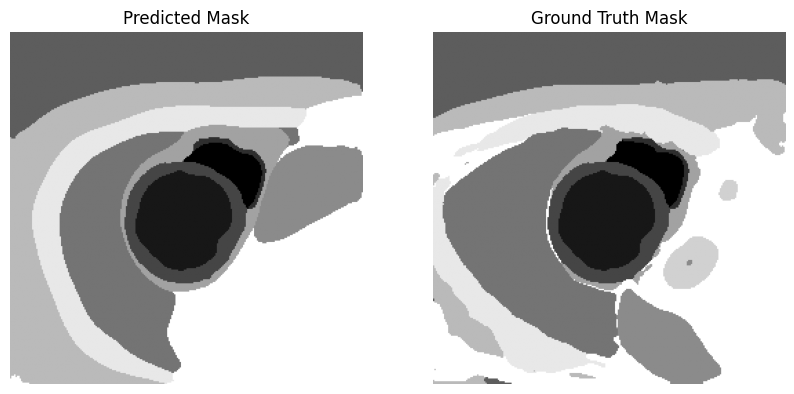

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(pred_mask, cmap='gray')
ax[0].set_title('Predicted Mask')
ax[1].imshow(data_concat['multiClassMasks'][5], cmap='gray')
ax[1].set_title('Ground Truth Mask')

ax[0].axis('off')
ax[1].axis('off')
plt.show()

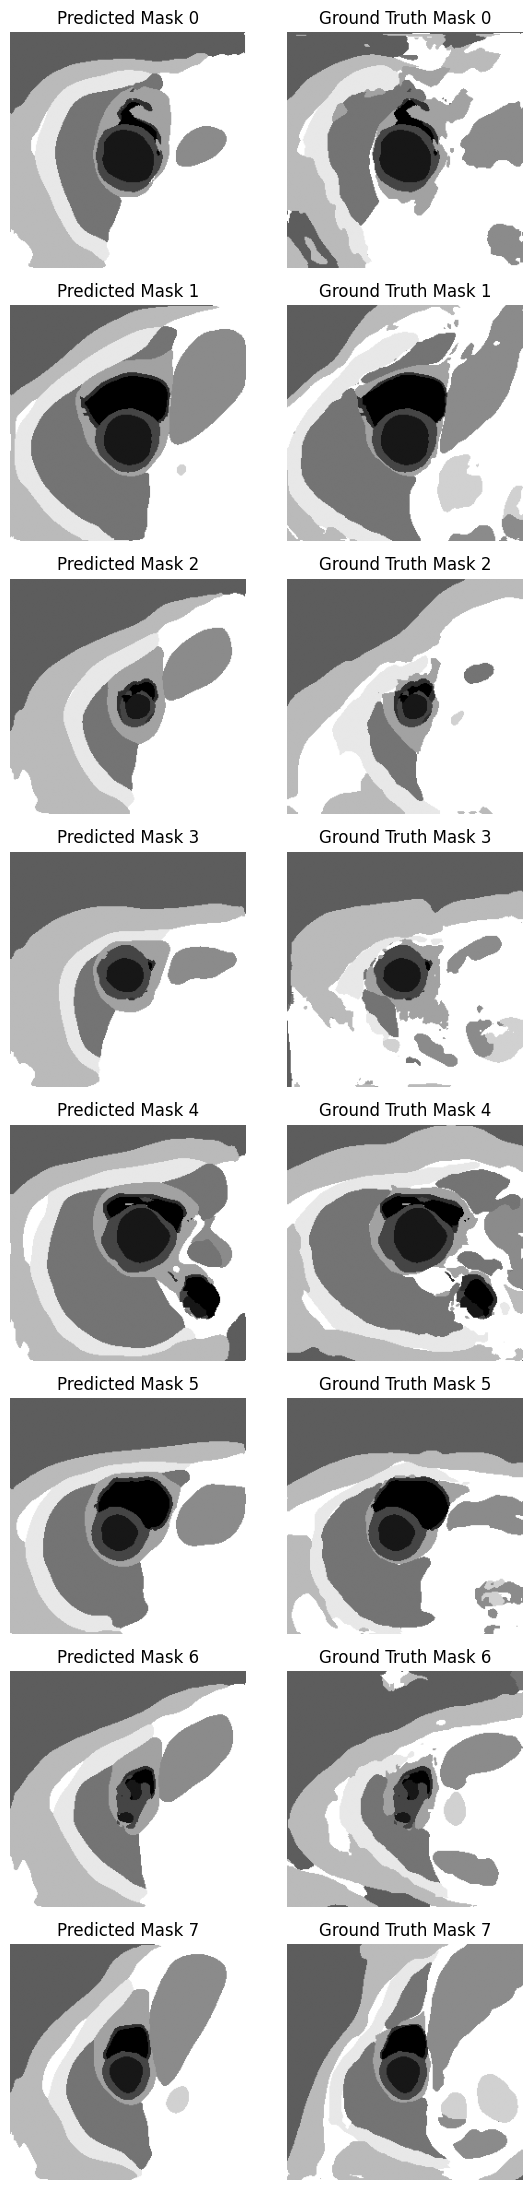

In [12]:
# Show all predicted batch
batch_size = pred_mask_batch.shape[0] // 2
fig, axes = plt.subplots(batch_size, 2, figsize=(6, 22))
for i in range(batch_size):
    axes[i, 0].imshow(pred_mask_batch[i], cmap='gray')
    axes[i, 0].set_title(f'Predicted Mask {i}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(batch['multiClassMask'][i].cpu().numpy(), cmap='gray')
    axes[i, 1].set_title(f'Ground Truth Mask {i}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

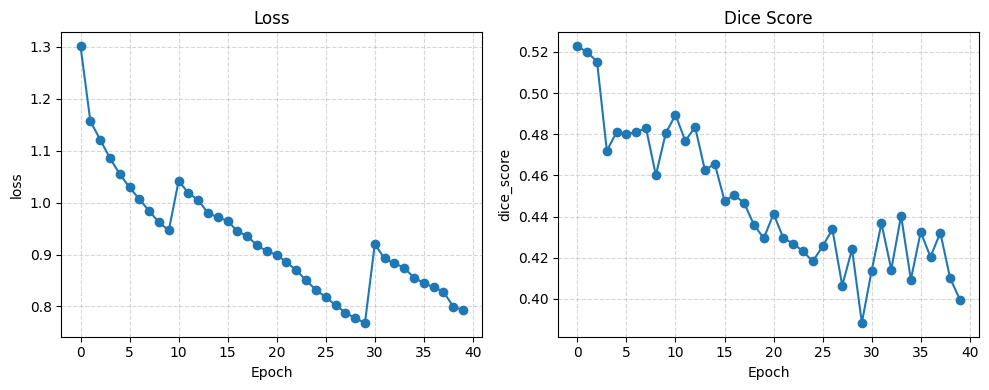

In [13]:
# for metrics 1
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

for ax, (key, values) in zip(axes, metrics.items()):
    ax.plot(values, marker='o')
    ax.set_title(key.replace('_', ' ').title())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(key)
    # ax.set_xticks(range(len(values)))
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()